# Classificazione di valori tiroidei

## Abstract
Questo notebook analizza il [Dataset Thyroid disease](https://www.kaggle.com/datasets/emmanuelfwerr/thyroid-disease-data).

L'obiettivo di quest'analisi è sviluppare e confrontare due approcci di classificazione, uno basato su algoritmi tradizionali di machine learning e uno su deep learning, per selezionare il modello con le performance migliori.

L'analisi è iniziata con un'esplorazione del dataset. I grafici hanno mostrato le problematiche riguardanti i dati: lo **sbilanciamento delle classi** e la **correlazione tra le variabili numeriche** (i valori sierologici).

Successivamente, durante il processo di **data cleaning**, sono state rimosse righe e colonne non informative, con pochi dati e inconsistenze.

È stata applicata la codifica **dummy** per le variabili categoriche e **nominale** per la variabile target.

I dati sono stati divisi in *_Training_*, *_Validation_* e *_Test_* secondo un protocollo sperimentale.

Dopo sono stati preprocessati per imputare e normalizzare le realizzazioni delle variabili numeriche e bilanciare le classi.

Finalmente, i due classificatori sono stati allenati sui dati di training, gli iperparametri sono stati ottimizzati mediante validazione.

Dalle metriche di classificazione, che forniscono una stima della qualità di un modello, è stato scelto quello che ha avuto una performance migliore, infine valutato sui dati di test.





### Diagnosi disponibili nella variabile target
- nessuna condizione patologica `-`
- hyperthyroid conditions: 
    - A   hyperthyroid 
    - B   T3 toxic 
    - C   toxic goitre 
    - D   secondary toxic 

- hypothyroid conditions: 
    - E   hypothyroid
    - F   primary hypothyroid
    - G   compensated hypothyroid
    - H   secondary hypothyroid


### Significato dei valori sierologici misurati

**_T3_** - Triiodotironina (L-3,5,3’-triiodotironina), ormone tiroideo attivo.

**_TT4_** - Total T4 (tiroxina totale), ormone secreto dalla tiroide (L-tiroxina), comprende la frazione libera e quella legata alle proteine plasmatiche.

**_TBG_** - Thyroxine-Binding Globulin, principale proteina plasmatica che lega e trasporta T3 e T4 nel sangue.

**_T4U_** - T4 Uptake, misura indirettamente la capacità della TBG di legare la T4.

**_TSH_** - Thyroid-Stimulating Hormone (ormone tireotropo), secreto dall’ipofisi per regolare la produzione di T3 e T4 nella tiroide.

**_FTI_** - Free Thyroxine Index, stima della frazione libera di T4 indipendente dalla concentrazione di TBG.
Approssimativamente calcolato come: $FTI=TT4×T4U$


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#lettura del dataset
df = pd.read_csv("thyroidDF.csv")
thyroid_dataset = df.copy()
thyroid_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9172 entries, 0 to 9171
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  9172 non-null   int64  
 1   sex                  8865 non-null   object 
 2   on_thyroxine         9172 non-null   object 
 3   query_on_thyroxine   9172 non-null   object 
 4   on_antithyroid_meds  9172 non-null   object 
 5   sick                 9172 non-null   object 
 6   pregnant             9172 non-null   object 
 7   thyroid_surgery      9172 non-null   object 
 8   I131_treatment       9172 non-null   object 
 9   query_hypothyroid    9172 non-null   object 
 10  query_hyperthyroid   9172 non-null   object 
 11  lithium              9172 non-null   object 
 12  goitre               9172 non-null   object 
 13  tumor                9172 non-null   object 
 14  hypopituitary        9172 non-null   object 
 15  psych                9172 non-null   o

In [2]:
#Selezione dei dati di interesse
diagnoses =  {
    "-" : "normal",
    "A" : "hyperthyroid",
    "B" : "hyperthyroid",
    "C" : "hyperthyroid",
    "D" : "hyperthyroid",
    "E" : "hypothyroid",
    "F" : "hypothyroid",
    "G" : "hypothyroid",
    "H" : "hypothyroid"}
#remapping del target
thyroid_dataset["target"] = thyroid_dataset["target"].map(diagnoses)
#rimozione righe senza target...
thyroid_dataset = thyroid_dataset[~thyroid_dataset["target"].isna()]

## Descrizione & Visualizzazione

### Visualizzazione delle classi sbilanciate

target
normal          0.897297
hypothyroid     0.078585
hyperthyroid    0.024119
Name: proportion, dtype: float64


<Axes: xlabel='target', ylabel='FTI'>

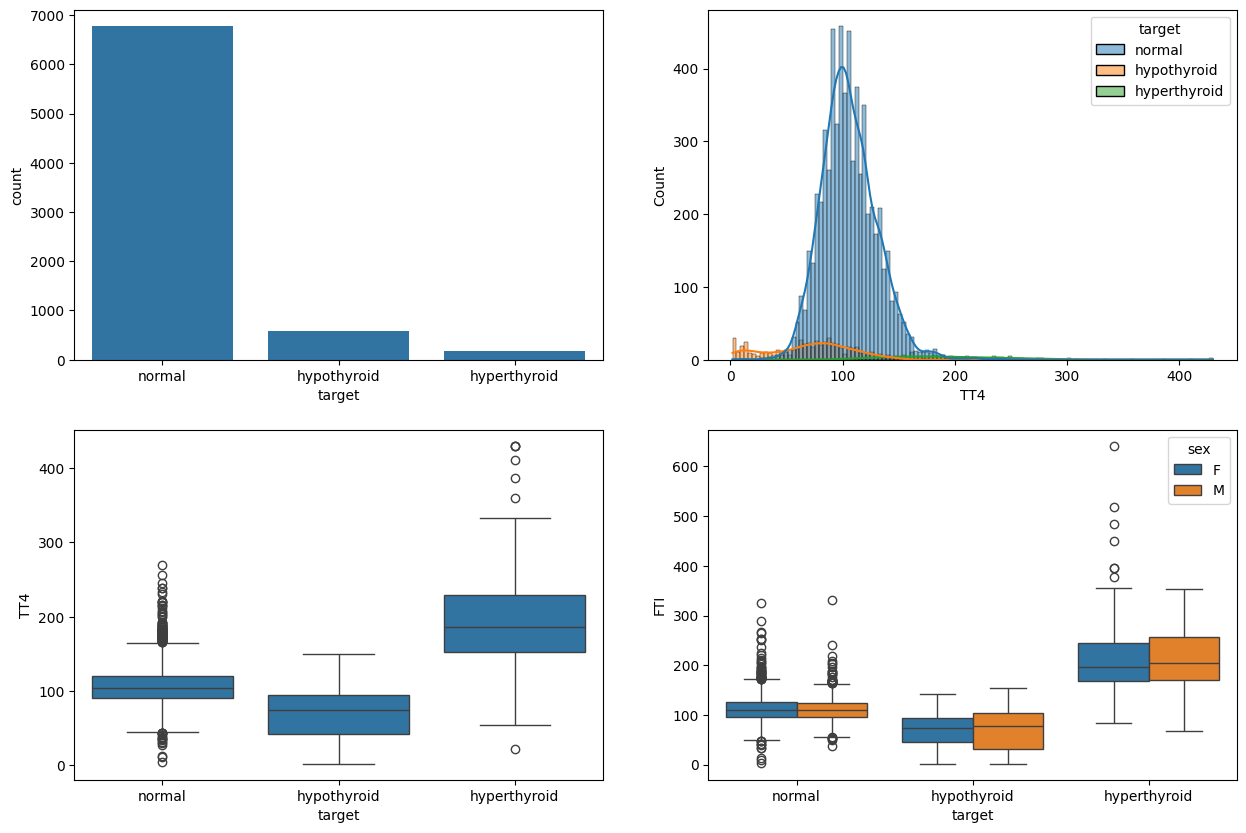

In [3]:
# figura 1:
# countplot target

print(thyroid_dataset["target"].value_counts(normalize=True))
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

#questo è il grafico mostrato nel report sintetico
sns.countplot(x="target", data=thyroid_dataset, ax=ax[0,0])

sns.histplot(x="TT4", hue="target", data=thyroid_dataset, kde=True, ax=ax[0,1])
sns.boxplot(x="target", y="TT4", data=thyroid_dataset, ax=ax[1,0])
sns.boxplot(x="target", y="FTI", hue="sex",data=thyroid_dataset, ax=ax[1,1])

### Correlazione tra variabili numeriche

In [4]:
#sierological_target = thyroid_dataset.iloc[:,-6:]
#plt.figure(figsize=(15, 5))
#sns.heatmap(sierological_target.corr(), annot=True)

sierological = thyroid_dataset.select_dtypes("float64")
# correlazione dei valori sierologici nelle diverse classi
#sns.pairplot(vars=sierological_target.columns, hue="target", data=thyroid_dataset)

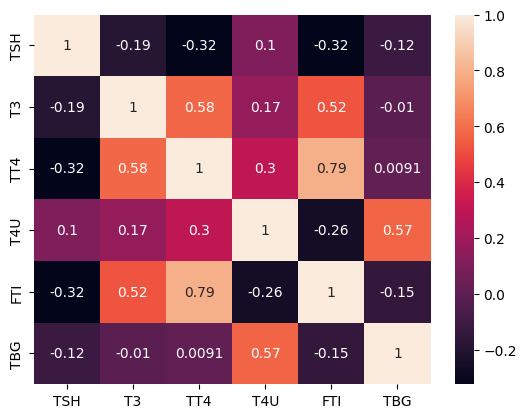

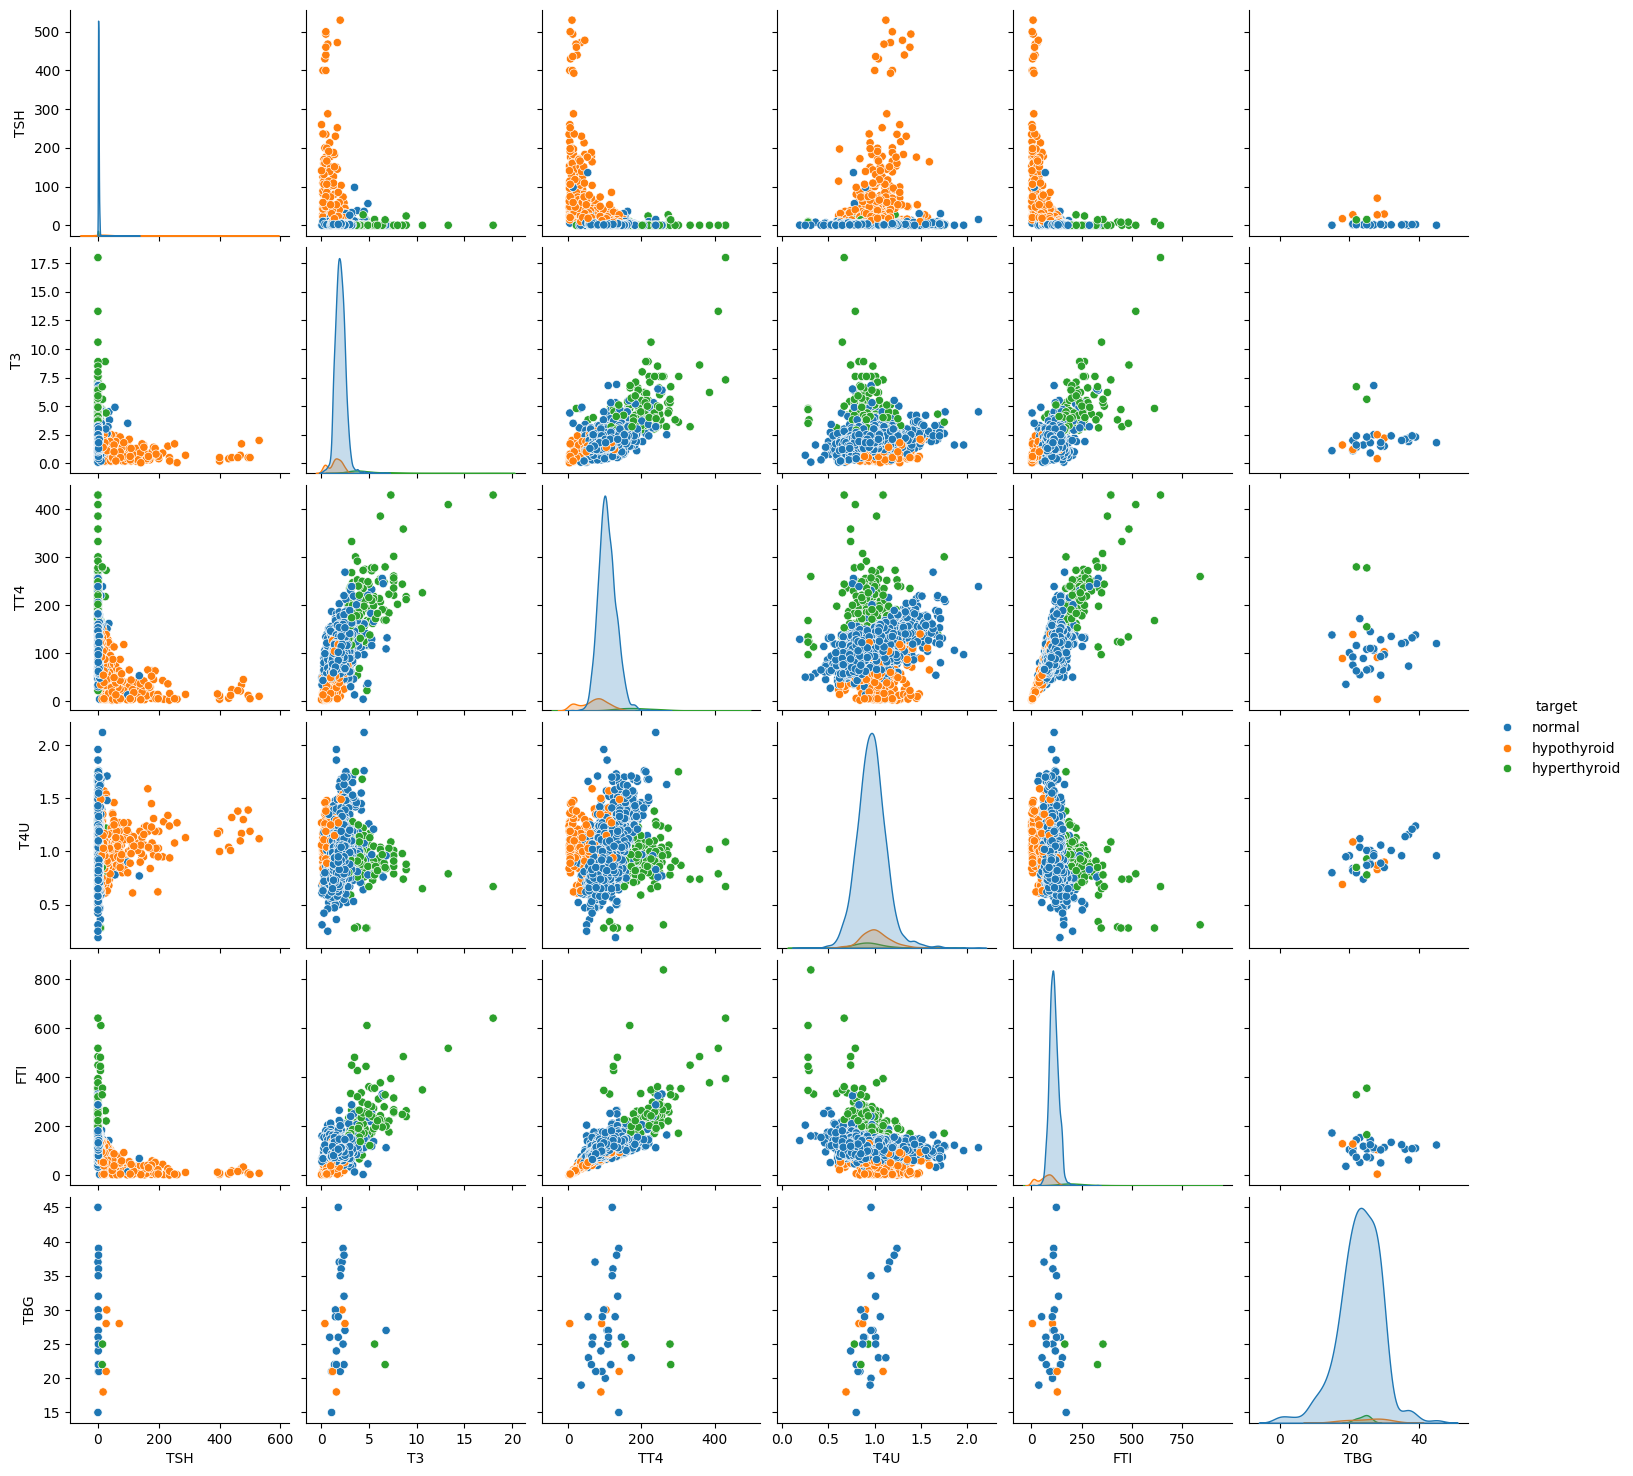

In [4]:
import seaborn as sns
sierological = thyroid_dataset.select_dtypes("float64")

sns.heatmap(sierological.corr(), annot=True)
#correlazione dei valori sierologici nelle diverse classi
sns.pairplot(vars=sierological.columns, hue="target", data=thyroid_dataset)


### Motivazione della normalizzazione dei valori sierologici

,TSH,T3,TT4,T4U,FTI,TBG
count,6824.000000,5337.000000,7192.000000,6870.000000,6877.000000,259.000000
mean,5.421753,2.020935,105.203373,0.967322,110.571745,22.955019
std,26.080471,0.809865,32.606462,0.162315,36.600867,6.088392
min,0.005000,0.050000,2.000000,0.190000,1.400000,0.100000
25%,0.570000,1.600000,87.000000,0.870000,93.000000,20.000000
50%,1.400000,2.000000,103.000000,0.960000,108.000000,23.000000
75%,2.700000,2.300000,121.000000,1.060000,125.000000,27.000000
max,530.000000,18.000000,430.000000,2.120000,839.000000,45.000000


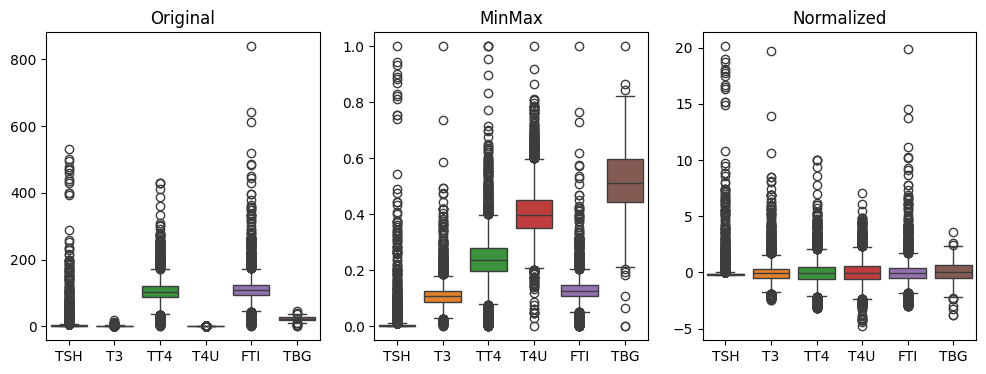

In [5]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
scaler = MinMaxScaler()
normalizer = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(sierological), columns=sierological.columns)
df_normalized = pd.DataFrame(normalizer.fit_transform(sierological), columns=sierological.columns)
#sns.lineplot(data=df_scaled)
#plt.title("Variabili scalate tra 0 e 1 (range relativo)")
#plt.show()
ax[0].set_title("Original")
sns.boxplot(sierological, ax=ax[0])
ax[1].set_title("MinMax")
sns.boxplot(df_scaled, ax=ax[1])
ax[2].set_title("Normalized")
sns.boxplot(df_normalized, ax=ax[2])

sierological.describe()

### Pairplot valori sierologici in base al sesso

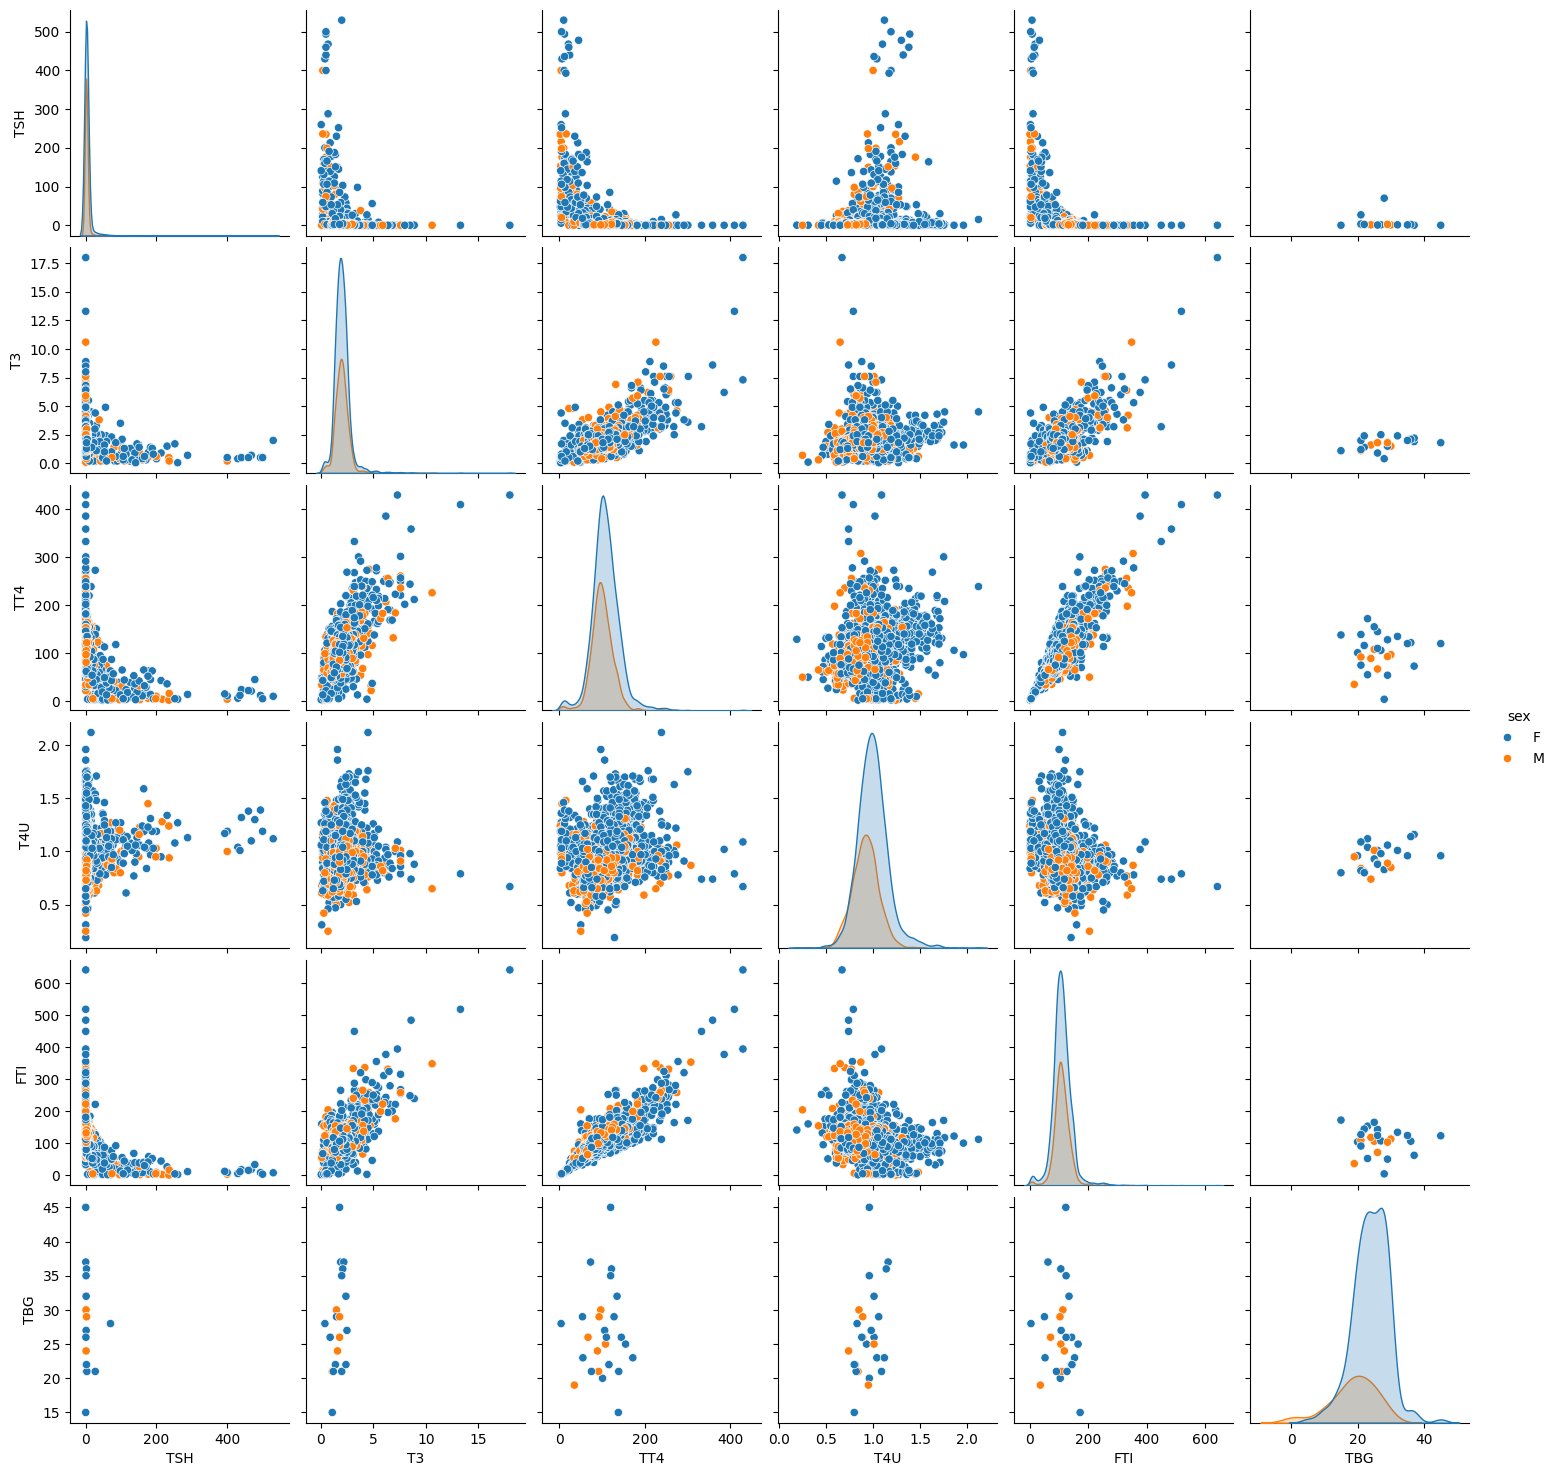

In [6]:
sns.pairplot(vars=sierological.columns, hue="sex", data=thyroid_dataset)

## Data Cleaning

### Rimozione colonne ridondanti e non utilizzate

In [7]:
### CLEANING ###
#rimozione colonne inutili  _measured, patient_id ecc...
dropped = ["TSH_measured", "T3_measured", "TT4_measured", "T4U_measured", "FTI_measured", "TBG_measured", "referral_source", "patient_id", "query_hypothyroid", "query_hyperthyroid", "query_on_thyroxine"]
thyroid_dataset.drop(columns=dropped, inplace=True)

### Remapping e Encoding di alcune feature categoriche
Come encoding del target ho scelto delle label nominali
```
normal: 0
hypothyroid: 1
hyperthyroid: 2
```
Scelto come iris, nel modello deep userò `sparse_categorical_crossentropy`

In [8]:
#encoding del target
target_encoding = {"normal":0, "hypothyroid":1, "hyperthyroid":2}
thyroid_dataset["target"] = thyroid_dataset["target"].map(target_encoding).astype("int")


#sex M e F encoding
sex_encoding = {"M": 0, "F":1}

#remapping categoriche
categorical_labels = {"t":1, "f":0}
categorical_columns = list(thyroid_dataset.select_dtypes("O").columns)
categorical_columns.remove("sex")
#categorical_columns.remove("target")

for col in categorical_columns:
    thyroid_dataset[col] = thyroid_dataset[col].map(categorical_labels).astype("int")

### Gestione dei dati mancanti

In [9]:
#MISSING CATEGORICHE

#percentuale categorical f vs t
missing_categorical = pd.DataFrame()
missing_categorical["tot"] = thyroid_dataset.loc[:,categorical_columns].sum()
missing_categorical["%t/f"] = round(missing_categorical["tot"] / len(thyroid_dataset) * 100, 2)
missing_categorical

,tot,%t/f
on_thyroxine,847,11.22
on_antithyroid_meds,92,1.22
sick,280,3.71
pregnant,33,0.44
thyroid_surgery,106,1.40
I131_treatment,140,1.86
lithium,86,1.14
goitre,74,0.98
tumor,191,2.53
hypopituitary,0,0.00


In [10]:
# MISSING NUMERICHE
missing_numerical = pd.DataFrame()
missing_numerical["tot"] = thyroid_dataset.select_dtypes("float64").isnull().sum()
missing_numerical["percentuale"] = round(missing_numerical["tot"] / len(thyroid_dataset) * 100, 2)
missing_numerical

,tot,percentuale
TSH,722,9.57
T3,2209,29.27
TT4,354,4.69
T4U,676,8.96
FTI,669,8.87
TBG,7287,96.57


In [11]:
### CLEANING ###
#quanti missing in percentuale
#rimozione poco informativi TBG, il 97% dei dati sono mancanti
#imputation e rimozione righe con più di due colonne missing dei valori sierologici

thyroid_dataset.drop(columns="TBG", inplace=True) #troppi NaN, poco informativa

#drop FTI... è correlata
#thyroid_dataset.drop(columns="FTI", inplace=True)
#thyroid_dataset.drop(columns="TSH", inplace=True) #vediamo se il modello distingue ancora hypo e hyper


thyroid_dataset.drop(columns="hypopituitary", inplace=True) #troppi f, poco informativa.
thyroid_dataset = thyroid_dataset[thyroid_dataset["age"] <= 100] #rimosse age inconsistent, 3 realizzazioni hanno valori insensati

In [12]:
#rimozione delle righe con più di due colonne missing

#solo dove sono presenti tutti i dati...
#thyroid_dataset = thyroid_dataset[thyroid_dataset.select_dtypes("float64").isnull().sum(axis=1) < 1]
#massimo un valore mancante
#thyroid_dataset = thyroid_dataset[thyroid_dataset.select_dtypes("float64").isnull().sum(axis=1) < 2]
#ecc...
thyroid_dataset = thyroid_dataset[thyroid_dataset.select_dtypes("float64").isnull().sum(axis=1) < 3]
#su 5 valori se ne mancano 3 non saprei...


missing_numerical = pd.DataFrame()
missing_numerical["tot"] = thyroid_dataset.select_dtypes("float64").isnull().sum()
missing_numerical["percentuale"] = round(missing_numerical["tot"] / len(thyroid_dataset) * 100, 2)
missing_numerical

,tot,percentuale
TSH,417,5.82
T3,1922,26.82
TT4,7,0.10
T4U,301,4.20
FTI,294,4.10


In [13]:
# imputation di sex
# se pregnant metto f
thyroid_dataset[(thyroid_dataset["sex"].isna() == True) & (thyroid_dataset["pregnant"] == 1)]
#a 73 anni mi sembra difficile che sia incinta...

#tanto si tratta principalmente di normal, però alcuni casi patologici potrebbero essere utili... forse imputation vale la pena
print("Righe con Sex mancante")
print(thyroid_dataset[thyroid_dataset["sex"].isnull()]["target"].value_counts())


#per adesso drop...
thyroid_dataset = thyroid_dataset[thyroid_dataset["sex"].isnull() == False]
thyroid_dataset["sex"] = thyroid_dataset["sex"].map(sex_encoding).astype("int")

Righe con Sex mancante
target
0    196
1     21
2     15
Name: count, dtype: int64


In [14]:
#CLEAN CHECK
print("Dimensioni dataset dopo cleaning: ", thyroid_dataset.shape)
thyroid_dataset.isnull().sum()

Dimensioni dataset dopo cleaning:  (6933, 18)


age                       0
sex                       0
on_thyroxine              0
on_antithyroid_meds       0
sick                      0
pregnant                  0
thyroid_surgery           0
I131_treatment            0
lithium                   0
goitre                    0
tumor                     0
psych                     0
TSH                     402
T3                     1858
TT4                       6
T4U                     290
FTI                     283
target                    0
dtype: int64

## Train-Validation-Test Split

Approccio sperimentale:
- 15% Test
- 15% Validation
- 70% Training

In [15]:
from sklearn.model_selection import train_test_split

X = thyroid_dataset.drop(columns="target")
y = thyroid_dataset["target"]

#X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.15, random_state=0)

#richiesto in realtà così 15% 15% 70%

#Primo split (Train+Validation)-Test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, stratify=y, test_size=0.15, random_state=0)

#Secondo split Train-Validation
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.1765, random_state=0)
# Perché? Due split, quindi 0.1765 * 0.85 = 0.15  (Grazie...)

Train:
 target
0    0.895095
1    0.081204
2    0.023702
Name: proportion, dtype: float64 

Validation:
 target
0    0.895293
1    0.080692
2    0.024015
Name: proportion, dtype: float64 

Test:
 target
0    0.895192
1    0.080769
2    0.024038
Name: proportion, dtype: float64 



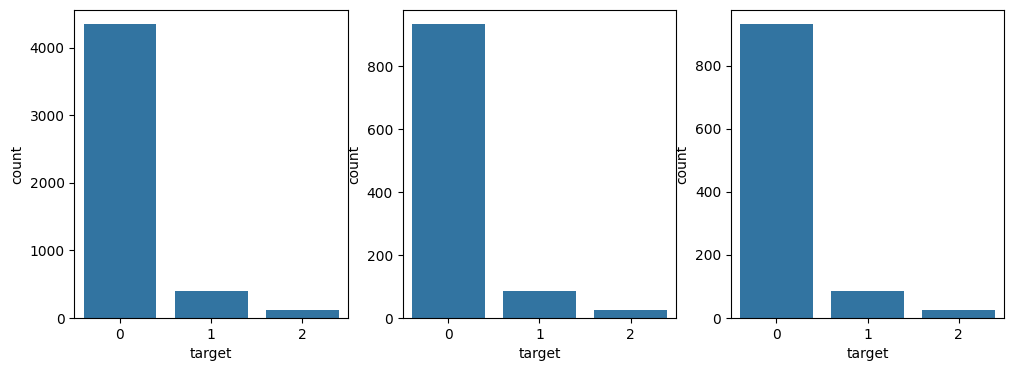

In [16]:
# Ho stratificato per y, quindi le proporzioni del target si sono mantenute
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.countplot(x="target", data=pd.DataFrame(y_train), ax=ax[0])
sns.countplot(x="target", data=pd.DataFrame(y_valid), ax=ax[1])
sns.countplot(x="target", data=pd.DataFrame(y_test), ax=ax[2])
print("Train:\n", y_train.value_counts(normalize=True), "\n")
print("Validation:\n", y_valid.value_counts(normalize=True), "\n")
print("Test:\n", y_test.value_counts(normalize=True), "\n")

## Data Preprocessing
Viene implementata una funzione che crea una pipeline di processamento dei dati. Ho testato la tecnica di resampling "SMOTE", ma, come si vedrà in seguito, ho deciso di utilizzare le classi sbilanciate e applicare dei pesi per le classi durante il training dei modelli.

In [17]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

def preprocess_data(X_train, y_train, X_valid, X_test, 
                    scale_only_float64=True, apply_smote=True, random_state=42):
    """
    Pipeline di preprocessing che mantiene i nomi delle colonne e la struttura DataFrame.
    
    Parameters:
    -----------
    X_train, X_valid, X_test : pd.DataFrame
        I dataset di input
    y_train : pd.Series
        Target del training set
    scale_only_float64 : bool
        Se True, scala solo le colonne float64
    apply_smote : bool
        Se applicare SMOTE al training set
    """
    
    # Salva i nomi delle colonne e l'ordine originale
    original_columns = X_train.columns.tolist()
    
    # Identifica le colonne da processare
    float64_columns = X_train.select_dtypes(include='float64').columns.tolist()
    other_columns = [col for col in original_columns if col not in float64_columns]
    
    print(f"Colonne float64 da processare: {len(float64_columns)}")
    print(f"Altre colonne da mantenere: {len(other_columns)}")
    
    # Imputation (solo dei valori sierologici)
    imputer = SimpleImputer(strategy='median') # Median, oppure mediana per classe target? Funziona

    X_train_float_imputed = pd.DataFrame(
        imputer.fit_transform(X_train[float64_columns]),
        columns=float64_columns,
        index=X_train.index)
    
    X_valid_float_imputed = pd.DataFrame(
        imputer.transform(X_valid[float64_columns]),
        columns=float64_columns,
        index=X_valid.index)
    
    X_test_float_imputed = pd.DataFrame(
        imputer.transform(X_test[float64_columns]),
        columns=float64_columns,
        index=X_test.index)
    
    # Normalizzazione
    scaler = StandardScaler()
    
    X_train_float_scaled = pd.DataFrame(
        scaler.fit_transform(X_train_float_imputed),
        columns=float64_columns,
        index=X_train.index)
    
    X_valid_float_scaled = pd.DataFrame(
        scaler.transform(X_valid_float_imputed),
        columns=float64_columns,
        index=X_valid.index)
    
    X_test_float_scaled = pd.DataFrame(
        scaler.transform(X_test_float_imputed),
        columns=float64_columns,
        index=X_test.index)
    
    # RICOMBINA LE COLONNE (mantenendo l'ordine originale)
    # Training
    X_train_processed = pd.concat([
        X_train[other_columns],  # Colonne non trasformate
        X_train_float_scaled      # Colonne float64 trasformate
    ], axis=1)
    X_train_processed = X_train_processed[original_columns]  # Ripristina ordine originale
    
    # Validation
    X_valid_processed = pd.concat([
        X_valid[other_columns],
        X_valid_float_scaled
    ], axis=1)
    X_valid_processed = X_valid_processed[original_columns]
    
    # Test
    X_test_processed = pd.concat([
        X_test[other_columns],
        X_test_float_scaled
    ], axis=1)
    X_test_processed = X_test_processed[original_columns]

    print("\nShape prima del bilanciamento:")
    print(f"X_train: {X_train_processed.shape}, y_train: {Counter(y_train)}")
    
    # SMOTE (solo su training)
    if apply_smote:
        smote = SMOTE(random_state=random_state)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)
        
        # Converti di nuovo in DataFrame mantenendo i nomi delle colonne
        X_train_final = pd.DataFrame(
            X_train_balanced,
            columns=original_columns
        )
        y_train_final = pd.Series(y_train_balanced, name=y_train.name if hasattr(y_train, 'name') else 'target')
        
        print(f"Shape dopo SMOTE: {X_train_final.shape}, y_train: {Counter(y_train_final)}")
    else:
        X_train_final = X_train_processed
        y_train_final = y_train
    
    # Validation e test rimangono invariati per y
    X_valid_final = X_valid_processed
    X_test_final = X_test_processed
    
    print("\nShape finali:")
    print(f"X_train: {X_train_final.shape} - Columns: {X_train_final.columns.tolist()[:5]}...")
    print(f"X_valid: {X_valid_final.shape} - Columns: {X_valid_final.columns.tolist()[:5]}...")
    print(f"X_test: {X_test_final.shape} - Columns: {X_test_final.columns.tolist()[:5]}...")
    
    # Verifica che le colonne siano identiche
    assert list(X_train_final.columns) == list(X_valid_final.columns) == list(X_test_final.columns), \
        "Le colonne non corrispondono tra i dataset!"
    
    return X_train_final, y_train_final, X_valid_final, X_test_final


# Effettuo il preprocessing
X_train_final, y_train_final, X_valid_final, X_test_final = preprocess_data(
    X_train, y_train, 
    X_valid, X_test,
    scale_only_float64=True,
    apply_smote=False
)

# Verifica
print("\n✅ Preprocessing completato!")

Colonne float64 da processare: 5
Altre colonne da mantenere: 12

Shape prima del bilanciamento:
X_train: (4852, 17), y_train: Counter({0: 4343, 1: 394, 2: 115})

Shape finali:
X_train: (4852, 17) - Columns: ['age', 'sex', 'on_thyroxine', 'on_antithyroid_meds', 'sick']...
X_valid: (1041, 17) - Columns: ['age', 'sex', 'on_thyroxine', 'on_antithyroid_meds', 'sick']...
X_test: (1040, 17) - Columns: ['age', 'sex', 'on_thyroxine', 'on_antithyroid_meds', 'sick']...

✅ Preprocessing completato!


### Feature Selection con SFS

Inizio selezione feature... (può richiedere alcuni minuti)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  17 | elapsed:    1.7s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    2.3s finished

[2025-11-13 21:06:29] Features: 1/17 -- score: 0.889280901742066[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  16 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    1.4s finished

[2025-11-13 21:06:31] Features: 2/17 -- score: 0.8955451249306771[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.8s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    1.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.3s finished

[2025-11-13 21:06:32] Features: 3/17 -- score: 0.8986152003568162[Parallel(n_jobs=-1)]: Using backen

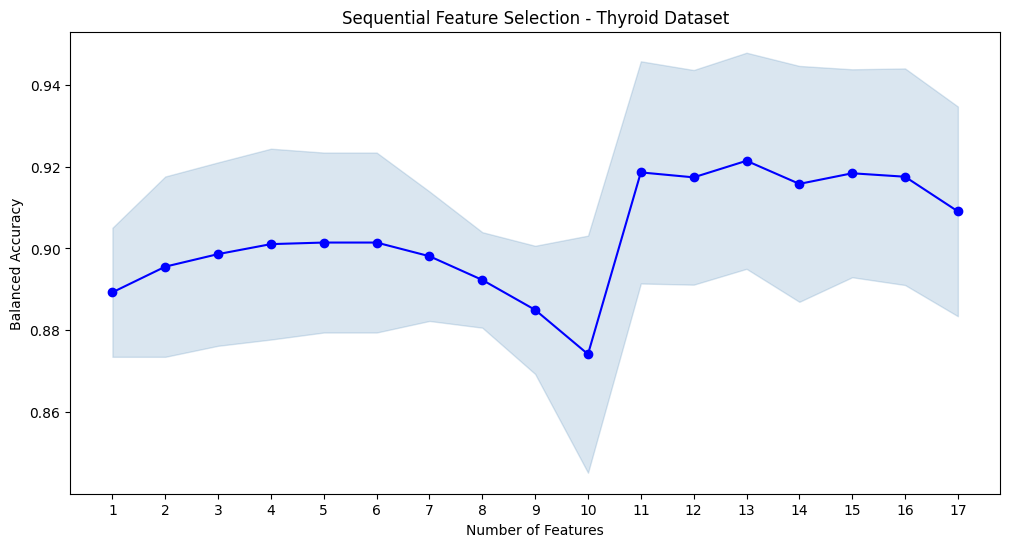


✅ Feature selezionate (13): ['on_thyroxine', 'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment', 'lithium', 'goitre', 'psych', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']
Score migliore: 0.9214


In [18]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, balanced_accuracy_score
import matplotlib.pyplot as plt


# Configurazione SFS
base_rf_thyroid = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # IMPORTANTE per classi sbilanciate
)


sfs_thyroid = SFS(
    estimator=base_rf_thyroid,
    k_features='best',  # Trova automaticamente il numero ottimale
    forward=True,
    floating=False,
    scoring=make_scorer(balanced_accuracy_score),  # Metrica migliore per sbilanciamento
    cv=5,
    n_jobs=-1,
    verbose=2  # Mostra progresso
)

# Fit su training set (Non su tutto X)
print("Inizio selezione feature... (può richiedere alcuni minuti)")
sfs_thyroid.fit(X_train_final, y_train_final)

# Visualizza risultati
fig = plot_sfs(sfs_thyroid.get_metric_dict(), 
               kind='std_dev', 
               figsize=(12, 6))
plt.title('Sequential Feature Selection - Thyroid Dataset')
plt.ylabel('Balanced Accuracy')
plt.show()

# Feature selezionate
selected_features = list(sfs_thyroid.k_feature_names_)
print(f"\n✅ Feature selezionate ({len(selected_features)}): {selected_features}")
print(f"Score migliore: {sfs_thyroid.k_score_:.4f}")

In [19]:
# Rieseguo SFS con il numero ottimale di features
sfs_optimal = SFS(
    estimator=base_rf_thyroid,
    k_features=13,  # il numero ottimale trovato
    forward=True,
    floating=False,
    scoring=make_scorer(balanced_accuracy_score),
    cv=5,
    n_jobs=-1,
    verbose=1
)

sfs_optimal.fit(X_train_final, y_train_final)
selected_features = list(sfs_optimal.k_feature_names_)

print(f"\nFeature finali selezionate: {selected_features}")

# Crea dataset ridotti selezionando solo le feature migliori
X_train_sfs = X_train_final[selected_features]
X_valid_sfs = X_valid_final[selected_features]
X_test_sfs = X_test_final[selected_features]

print(f"\nShape originali: Train={X_train_final.shape}, Ridotto={X_train_sfs.shape}")
print(f"Shape originali: Validation={X_valid_final.shape}, Ridotto={X_valid_sfs.shape}")
print(f"Shape originali: Test={X_test_final.shape}, Risotto={X_test_sfs.shape}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.2s finished
Features: 1/13[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  16 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    1.4s finished
Features: 2/13[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    1.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.3s finished
Features: 3/13[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  14 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    1.2s finished
Features: 4/13[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 


Feature finali selezionate: ['on_thyroxine', 'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment', 'lithium', 'goitre', 'psych', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']

Shape originali: Train=(4852, 17), Ridotto=(4852, 13)
Shape originali: Validation=(1041, 17), Ridotto=(1041, 13)
Shape originali: Test=(1040, 17), Risotto=(1040, 13)


## Modello Machine Learning

In [20]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Definisco i parametri da ottimizzare
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced']  # Per gestire sbilanciamento
}


ml_model = RandomForestClassifier(random_state=42)

# Usa balanced_accuracy come metrica per l'ottimizzazione
scorer = make_scorer(balanced_accuracy_score)

random_search = RandomizedSearchCV(
    ml_model, 
    param_grid, 
    n_iter=50,  # Numero di combinazioni da provare
    scoring=scorer,
    cv=5,  # Cross-validation
    verbose=1,
    n_jobs=-1,  # Usa tutti i core
    random_state=42
)


random_search.fit(X_train_sfs, y_train_final)
best_rf_model = random_search.best_estimator_
best_rf_model

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,n_estimators,50
,criterion,'gini'
,max_depth,10
,min_samples_split,10
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Modello Deep Learning

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 195 (780.00 B)

 Trainable params: 179 (716.00 B)

 Non-trainable params: 16 (64.00 B)

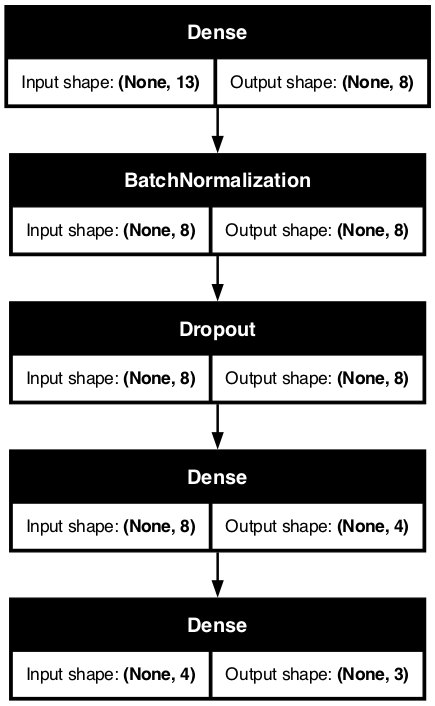

In [21]:
#Creazione del modello e visualizzazione

from tensorflow import keras
from keras import layers
from keras.utils import plot_model

deep_model = keras.Sequential([
    layers.Input((13,)),
    layers.Dense(units=8, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.1), # sembra faccia abbassare la curva di val_loss sotto train loss se eccessivo
    #layers.BatchNormalization(),
    layers.Dense(units=4, activation="relu"),
    #layers.BatchNormalization(),
    #layers.Dropout(rate=0.1),
    layers.Dense(3, activation="softmax")
])

deep_model.summary()
plot_model(deep_model, show_shapes=True, dpi=90)

In [22]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
]

#ottimizzazione con ADAM, la funzione di loss è crossentropy perché
#voglio una classificazione multi-classe
deep_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

#X_new = X_train_final.select_dtypes("float64")
#X_valid_new = X_valid_final.select_dtypes("float64")


#history = deep_model.fit(X_train_final, y_train_final, epochs=200, validation_data=(X_valid_final, y_valid), callbacks=callbacks, verbose=1)
#history = model.fit(X_train, y_train, epochs=, batch_size=, validation_split=0.1, callbacks= [], verbose=0)


#history = deep_model.fit(X_new, y_train_final, epochs=200, validation_data=(X_valid_new, y_valid), callbacks=callbacks, verbose=1)


history_sfs = deep_model.fit(
    X_train_sfs, y_train_final,
    validation_data=(X_valid_sfs, y_valid),
    epochs=150,    #numero eccessivo, l'early stopping ferma prima il training.
    #batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/150
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step - accuracy: 0.4285 - loss: 1.1196 - val_accuracy: 0.8982 - val_loss: 0.9218 - learning_rate: 0.0010
Epoch 2/150
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - accuracy: 0.8850 - loss: 0.7852 - val_accuracy: 0.9145 - val_loss: 0.6486 - learning_rate: 0.0010
Epoch 3/150
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - accuracy: 0.9075 - loss: 0.5244 - val_accuracy: 0.9097 - val_loss: 0.4145 - learning_rate: 0.0010
Epoch 4/150
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - accuracy: 0.9097 - loss: 0.3661 - val_accuracy: 0.9097 - val_loss: 0.3146 - learning_rate: 0.0010
Epoch 5/150
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - accuracy: 0.9171 - loss: 0.2950 - val_accuracy: 0.9135 - val_loss: 0.2654 - learning_rate: 0.0010
Epoch 6/150
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - accuracy: 0.9231 - loss: 0.2397 - val_accuracy: 0.9193 - val_loss: 0.2156 - learning_rate: 0.0010
Epoch 7/150
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - accuracy: 0.9

Text(0.5, 1.0, 'Accuracy (Training vs. Validation)')

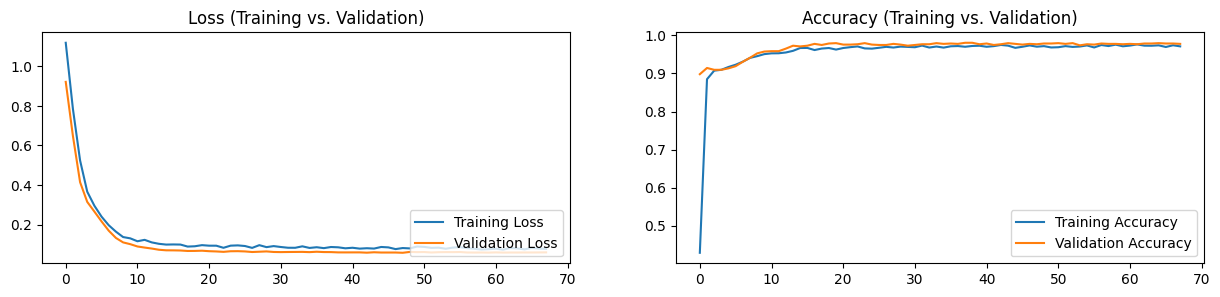

In [23]:
#Training e grafici (loss & accuracy)

history = pd.DataFrame(history_sfs.history)

plt.figure(figsize=(15, 3))

# Grafico delle loss
plt.subplot(1, 2, 1)
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.legend(loc="lower right")
plt.title("Loss (Training vs. Validation)")

# Grafico delle accuracy
plt.subplot(1, 2, 2)
plt.plot(history["accuracy"], label="Training Accuracy")
plt.plot(history["val_accuracy"], label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Accuracy (Training vs. Validation)")

## Confronto e Scelta Del Modello Migliore
Grafici dei benchmark per confrontare i modelli.

And the winner is...


In [24]:
ml_model_preds = best_rf_model.predict(X_valid_sfs)
ml_model_balanced_accuracy = balanced_accuracy_score(y_valid, ml_model_preds)
print(f"Machine learning balanced score sul Validation Set: {ml_model_balanced_accuracy:.4f}")


deep_model_preds = deep_model.predict(X_valid_sfs)
predicted_labels = np.argmax(deep_model_preds, axis=1).T
deep_model_balanced_accuracy = balanced_accuracy_score(y_valid, predicted_labels)
print(f"Deep learning Score balanced score sul Validation Set: {deep_model_balanced_accuracy:.4f}")

Machine learning balanced score sul Validation Set: 0.9665
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
Deep learning Score balanced score sul Validation Set: 0.8753


           Model  Precision    Recall  F1-score  Balanced Accuracy
0  Random forest   0.859345  0.966538  0.905099           0.966538
1  Deep Learning   0.902225  0.875312  0.888288           0.875312


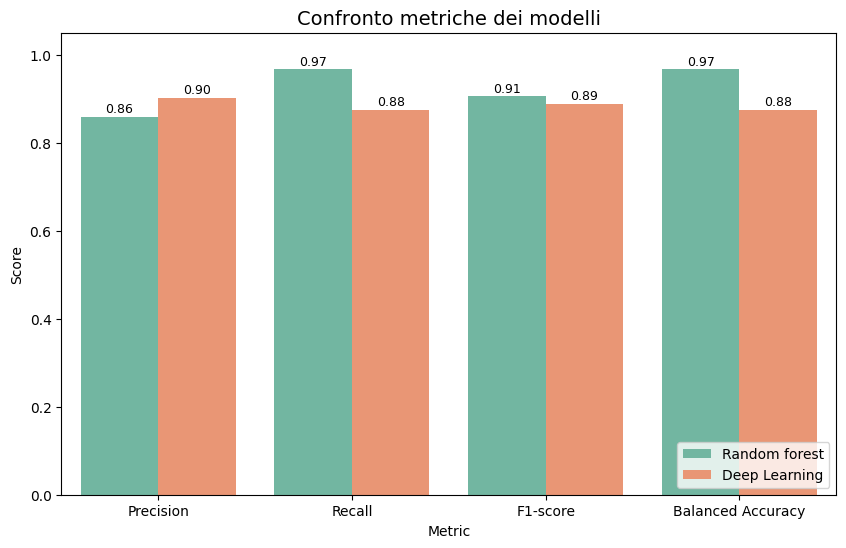

In [25]:
#classification reports

from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Calcolo le metriche per ciascun modello
metrics = {
    "Model": ["Random forest", "Deep Learning"],
    "Precision": [
        precision_score(y_valid, ml_model_preds, average='macro'),
        precision_score(y_valid, predicted_labels, average='macro')
    ],
    "Recall": [
        recall_score(y_valid, ml_model_preds, average='macro'),
        recall_score(y_valid, predicted_labels, average='macro')
    ],
    "F1-score": [
        f1_score(y_valid, ml_model_preds, average='macro'),
        f1_score(y_valid, predicted_labels, average='macro')
    ],
    "Balanced Accuracy": [
        balanced_accuracy_score(y_valid, ml_model_preds),
        balanced_accuracy_score(y_valid, predicted_labels)
    ]
}

df_metrics = pd.DataFrame(metrics)
print(df_metrics)
df_metrics = df_metrics.melt(id_vars="Model", 
                          value_vars=["Precision", "Recall", "F1-score", "Balanced Accuracy"],
                          var_name="Metric", value_name="Score")

plt.figure(figsize=(10,6))
sns.barplot(x="Metric", y="Score", hue="Model", data=df_metrics, palette="Set2")

# Aggiungi i valori sopra le barre
for i in range(len(df_metrics)):
    plt.text(
        x=i//2 + (-0.2 if df_metrics['Model'][i]=='Random forest' else 0.2),  # posizionamento barre affiancate
        y=df_metrics['Score'][i] + 0.01,
        s=f"{df_metrics['Score'][i]:.2f}",
        ha='center',
        fontsize=9
    )

plt.ylim(0,1.05)
plt.title("Confronto metriche dei modelli", fontsize=14)
plt.legend(loc="lower right")
plt.savefig("benchmarks.png")
#sns.barplot(x=["Precision", "Recall", "F1-score", "Balanced Accuracy"], hue="Model", data=df_metrics)

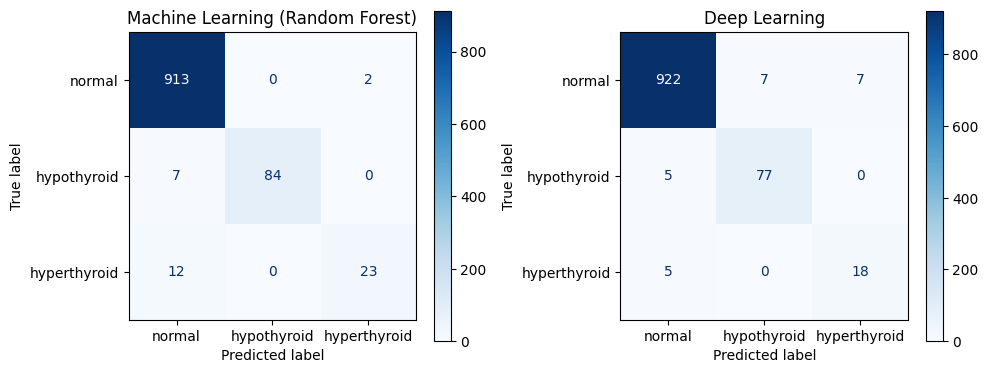

In [26]:
#confusion matrices

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

#machine learning
ml_model_cm = confusion_matrix(ml_model_preds, y_valid)
disp1 = ConfusionMatrixDisplay(confusion_matrix=ml_model_cm, display_labels=["normal", "hypothyroid", "hyperthyroid"])
ax[0].set_title("Machine Learning (Random Forest)")
disp1.plot(cmap="Blues", ax=ax[0])



#deep learning
deep_model_cm = confusion_matrix(predicted_labels, y_valid)
disp2 = ConfusionMatrixDisplay(confusion_matrix=deep_model_cm, display_labels=["normal", "hypothyroid", "hyperthyroid"])
ax[1].set_title("Deep Learning")
disp2.plot(cmap="Blues", ax=ax[1])

plt.tight_layout()
plt.savefig("cm_compare.png")

## Valutazione su Test Set e Performance

Balanced Accuracy finale sul test set: 0.9431


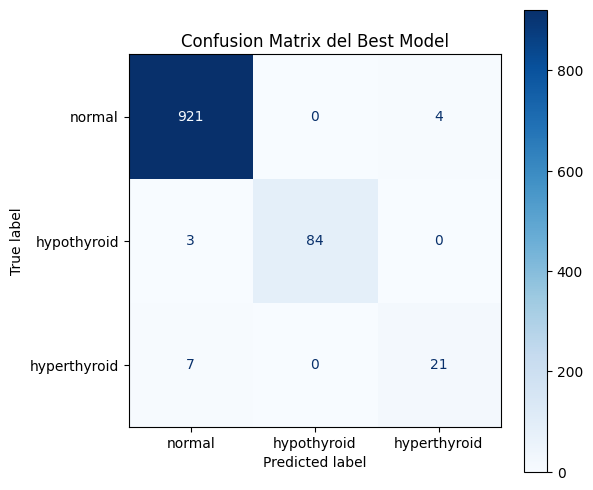

In [27]:
#Meglio rendere riutilizzabile in caso di miglioramento delle performance

best_model = deep_model if deep_model_balanced_accuracy > ml_model_balanced_accuracy else best_rf_model

if best_model == deep_model:
    test_preds = np.argmax(best_model.predict(X_test_sfs), axis=1)
else:
    test_preds = best_model.predict(X_test_sfs)

best_model_balanced_accuracy = balanced_accuracy_score(y_test, test_preds)
print(f"Balanced Accuracy finale sul test set: {best_model_balanced_accuracy:.4f}")

best_model_cm = confusion_matrix(test_preds, y_test)

fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=best_model_cm, display_labels=["normal", "hypothyroid", "hyperthyroid"])
disp.plot(cmap="Blues", ax=ax)
ax.set_title("Confusion Matrix del Best Model")
plt.savefig("test_cm.png")